# Simulation for the Raking-Ratio Estimator

In this notebook, we explore the effectiveness of the [raking-ratio](https://www.overleaf.com/project/6240b53cd03889544678526e) approach in simulations.
Concretely, we are interested in answering the following questions:

1. Does the raking-ratio estimator has a smaller MSE compared to the empirical estimator?
1. Does the MSE and marginal constraints of the raking-ratio estimator converges exponentially as the number of iterations goes to infinity?
1. (Optional) How does the MSE depend on the tail of the two marginals?

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr

# from pathos.multiprocessing import ProcessingPool as Pool


COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
LINESTYLE = ['-', '--', '-.', (0, (1, 1)), '-']
MARKER = ['8', 's', '', '', '^']

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['lines.markersize'] = 7.5
mpl.rcParams["mathtext.fontset"] = 'cm'
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
def generate(pmat, size):
    pairs = np.argwhere(pmat > -1)
    indices = npr.choice(len(pairs), size=size, p=pmat.reshape(-1), replace=True)
    return pairs[indices][:, 0], pairs[indices][:, 1]


def count_freq(X, Y, sizes):
    # count pairs
    pairs = list(zip(X, Y))
    ind, count = np.unique(pairs, axis=0, return_counts=True)
    cmat = np.zeros(sizes)
    cmat[ind[:, 0], ind[:, 1]] = count
    return cmat / len(pairs)


def raking_ratio(X, Y, marginals, num_iter):
    pmat = count_freq(X, Y, (len(marginals[0]), len(marginals[1])))
    if np.sum(np.sum(pmat, axis=1) == 0) + np.sum(np.sum(pmat, axis=0) == 0) > 0:
        raise RuntimeError(
            "Missing mass in this sample. Try a larger sample size.")
        
    est = [pmat]
    for _ in range(num_iter):
        pmat = (marginals[0] / np.sum(pmat, axis=1)).reshape(-1, 1) * pmat
        pmat = pmat * (marginals[1] / np.sum(pmat, axis=0))
        est.append(pmat)
    return est

In [3]:
def compute_error(size, prob, func, par, marginals, num_iter):
    success = False
    while not success:
        try:
            X, Y = generate(prob, size)
            est = raking_ratio(X, Y, marginals, num_iter)
            success = True
        except RuntimeError:
            pass
    err = [np.sum(mat * func) - par for mat in est]
    return err

In [4]:
def plot_error_size(sizes, errors, ses, num_iter):
    for i in range(num_iter+1):
        label = 'Empirical'
        if i > 0:
            label = f'Raking-{i}'
        plt.plot(sizes, errors[:, i], label=label, color=COLORS[i],
                 linestyle=LINESTYLE[i], marker=MARKER[i])
        plt.fill_between(sizes, errors[:, i]-ses[:, i], errors[:, i]+ses[:, i],
                         color=COLORS[i], alpha=0.3)
    
    plt.xlabel('Size')
    plt.ylabel(r'Size $\times$ MSE')
    plt.legend()
    
    
def plot_error_iter(iterations, errors, ses, sizes):
    for i, size in enumerate(sizes):
        label = f'n = {size}'
        plt.plot(iterations, errors[i], label=label, color=COLORS[i],
                 linestyle=LINESTYLE[i], marker=MARKER[i])
        plt.fill_between(iterations, errors[i]-ses[i], errors[i]+ses[i],
                         color=COLORS[i], alpha=0.3)
    
    plt.xlabel('Number of Iterations')
    plt.ylabel(r'Size $\times$ MSE')
    plt.legend()

## Convergence rate in the sample size

In this experiment, we compare the convergence rate of the raking-ratio estimator with the one of the empirical estimator as the sample size goes to infinity.
We conduct the experiment in the following steps:

1. Randomly generate a probability matrix $P$.
1. Randomly generate a matrix $F$ and treat $\langle P, F \rangle$ as the parameter $\theta$.
1. Repeat the following steps
    1. Randomly generate pairs from the above probability matrix.
    1. Estimate the parameter.
1. Compute the bias and the MSE.

In [8]:
npr.seed(552022)  # 05/05/2022

K = 20
prob = npr.rand(K, K)
prob /= np.sum(prob)
px, py = np.sum(prob, axis=1), np.sum(prob, axis=0)

fmat = npr.normal(loc=1, size=(K, K))
theta = np.sum(prob * fmat)
print(theta)

1.0959371314244022


In [11]:
marginals = (px, py)
n = 1000
num_iter = 2
X, Y = generate(prob, n)

pmat = count_freq(X, Y, (len(marginals[0]), len(marginals[1])))
if np.sum(np.sum(pmat, axis=1) == 0) + np.sum(np.sum(pmat, axis=0) == 0) > 0:
     raise RuntimeError("Missing mass in this sample. Try a larger sample size.")

est = [pmat]
for _ in range(num_iter):
     pmat = (marginals[0] / np.sum(pmat, axis=1)).reshape(-1, 1) * pmat
     pmat = pmat * (marginals[1] / np.sum(pmat, axis=0))
     est.append(pmat)
result = est[-1]

1.0

In [10]:
size_range = np.linspace(200, 2000, num=12).astype(int)
repeats = 50000

bias, mse = [], []
bias_std, mse_std = [], []

for size in size_range:
    num_iter = 4
    def worker(par):
        npr.seed(par[0])
        return compute_error(par[1], pmat, fmat, theta, (a, b), num_iter)
    
    with Pool(processes=20) as pool:
        errors = pool.map(worker, [(i, size) for i in range(repeats)])
    
    errors = np.asarray(errors)
    bias.append(np.mean(errors, axis=0))
    bias_std.append(np.std(errors, axis=0))
    mse.append(np.mean(errors**2*size, axis=0))
    mse_std.append(np.std(errors**2*size, axis=0))

In [11]:
mse = np.asarray(mse)
mse_std = np.asarray(mse_std)

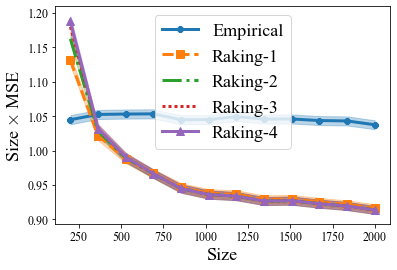

In [12]:
plot_error_size(size_range, mse, mse_std/np.sqrt(repeats), 4)

## Convergence rate in the number of raking iterations

In this experiment, we investigate the convergence rate of the raking-ratio estimator as the number of iterations goes to infinity.

In [17]:
size_range = [500, 1000, 1500, 2000, 2500]
repeats = 50000
num_iter = 11

bias2, mse2 = [], []
bias_std2, mse_std2 = [], []

for size in size_range:
    num_iter = 11
    def worker(par):
        npr.seed(par[0])
        return compute_error(par[1], pmat, fmat, theta, (a, b), par[2])
    
    with Pool(processes=20) as pool:
        errors = pool.map(worker, [(i, size, num_iter) for i in range(repeats)])
    
    errors = np.asarray(errors)
    bias2.append(np.mean(errors, axis=0))
    bias_std2.append(np.std(errors, axis=0))
    mse2.append(np.mean(errors**2*size, axis=0))
    mse_std2.append(np.std(errors**2*size, axis=0))

In [18]:
mse2 = np.asarray(mse2)
mse_std2 = np.asarray(mse_std2)

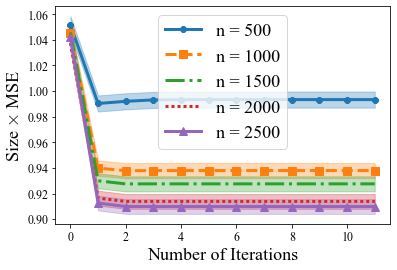

In [19]:
plot_error_iter(np.arange(num_iter+1).astype(int), mse2, mse_std2/np.sqrt(repeats), size_range)

In [20]:
mse2

array([[1.05181724, 0.99032704, 0.9920238 , 0.99312909, 0.99332334,
        0.99335795, 0.99336445, 0.99336573, 0.993366  , 0.99336606,
        0.99336608, 0.99336608],
       [1.0453509 , 0.93986267, 0.93783127, 0.93793202, 0.93794249,
        0.93794352, 0.93794363, 0.93794364, 0.93794364, 0.93794364,
        0.93794364, 0.93794364],
       [1.04582434, 0.92995686, 0.9275253 , 0.92756128, 0.92756537,
        0.92756572, 0.92756576, 0.92756576, 0.92756576, 0.92756576,
        0.92756576, 0.92756576],
       [1.03761515, 0.91642056, 0.91384572, 0.91384276, 0.9138428 ,
        0.91384276, 0.91384275, 0.91384275, 0.91384275, 0.91384275,
        0.91384275, 0.91384275],
       [1.04202304, 0.91257777, 0.90987532, 0.90985516, 0.90985427,
        0.90985421, 0.90985421, 0.90985421, 0.90985421, 0.90985421,
        0.90985421, 0.90985421]])